In [1]:
import os
import math
import pandas as pd
from autograd import grad
import autograd.numpy as np
import numpy as np1
import numpy.matlib
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.matlib import repmat

In [2]:
import sys
sys.path.append('../../Python/')
from Preprocessing import standardize, MaxMinScaler
from Evaluation import split_train_test_ma, train_model, eval_model_roc_2, split_train_test_ma_rd
from Databases import get_databases_path, get_database

In [3]:
theta = 1e-50

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_cost_function(w, X, Y, mui):
    R = Y.shape[1] # Number of annotators.
    D = X.shape[1] # Input space dimension
    N = X.shape[0] # Number of samples.
    
    sizew1 = D
    sizew2 = D*R;
    sizeW = sizew1 + sizew2
    
    W1 = w[0,0:sizew1].reshape(sizew1,1)
    W2 = w[0,sizew1:sizeW].reshape(D,R)
    pi = sigmoid(np.dot(X, W1))
    nt = sigmoid(np.dot(X,W2))
    
    Gr1 = np.dot(X.transpose(), (pi - mui))
    Gr2 = np.zeros((D, R))
    
    for j in range(R):
        aux = np.multiply(np.array(Y[:,j]).reshape(nt.shape[0],1), (2*mui-1)) + (1- mui) - np.array(nt[:,j]).reshape(nt.shape[0],1) 
        aux2 = np.sum((np.multiply(np1.matlib.repmat(aux, 1, D), X)), axis=0)
        Gr2[:,j] = -aux2
        g = np.concatenate((Gr1.flatten().reshape(1, sizew1), Gr2.flatten().reshape(1, sizew2)), axis=None)
    return g

           
def optimizer(X, Y, w_0, mui):
    params = w_0
    epsilon = 0.001
    normGrad = 300
    i=0
    while normGrad > 0.01 and i < 500:
        gr = grad_cost_function(params, X, Y, mui)
        params = params - epsilon * gr
        normGrad = LA.norm(gr)
        i+=1
    return params, normGrad
    
    
def train_mae(X_train, Y_train):
    X = X_train.copy()
    Y = Y_train.copy()
    
    X.loc[:,('b')] = np.zeros((X.shape[0],1))
    X = X.values
    Y = Y.values
    R = Y.shape[1] # Number of annotators.
    D = X.shape[1] # Input space dimension
    N = X.shape[0] # Number of samples.
    
    sizew1 = D
    sizew2 = D*R;
    sizeW = sizew1 + sizew2
    
    w = np.random.randn(1, sizeW)
    mui = np.array(Y.mean(axis=1)).reshape(Y.shape[0],1)
    
    w = repmat(np.dot(inv(np.dot(X.T,X) + np.eye(D)), np.dot(X.T,mui)),1,R+1)
    w = w.flatten().reshape(1, sizeW)
    
    w_0 = w
    loglik1 = 10000000
    difloglik = 100
    i = 0
    
    while difloglik > 0.1 and i < 100: 
        w, _ = optimizer(X, Y, w_0, mui)
        W1 = w[0,0:sizew1].reshape(sizew1,1)
        W2 = w[0,sizew1:sizeW].reshape(D,R)

        #E-step
        pi = sigmoid(np.dot(X,W1))
        aux = sigmoid(np.dot(X,W2))

        ai = np.multiply(np.power((1-aux),np.absolute(Y-1)),np.power(aux, (1-np.absolute(Y-1))))
        ai = np.array(np.prod(ai, axis=1)).reshape(ai.shape[0],1) 

        bi = np.multiply(np.power((1-aux),np.absolute(Y)),np.power(aux, (1-np.absolute(Y))))
        bi = np.array(np.prod(bi, axis=1)).reshape(bi.shape[0],1) 

        nummui = np.multiply(ai, pi)
        denmui = (np.multiply(ai, pi) + np.multiply(bi, (1-pi)))
        mui =  np.divide(nummui, denmui + theta)

        loglik2 = -(np.log(np.multiply(ai, pi) + theta) + np.multiply((1-pi), bi)).sum()
        difloglik = abs(loglik2 - loglik1)
        loglik1 = loglik2

        w_0 = w
        i+=1
        
    return w[0,0:sizew1].reshape(sizew1,1) 

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/breast-cancer 



/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Results

-- Global Precision --
0.9181286549707602


-- General Report --
              precision    recall  f1-score   support

         yes       0.91      0.96      0.94       108
          no       0.93      0.84      0.88        63

    accuracy                           0.92       171
   macro avg       0.92      0.90      0.91       171
weighted avg       0.92      0.92      0.92       171



-- Confusion Matrix --
     0   1
0  104   4
1   10  53

ROC Curve: 

ROC AUC:  0.9708994708994709


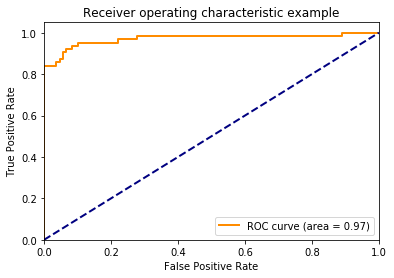

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/column 



/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Results

-- Global Precision --
0.8064516129032258


-- General Report --
              precision    recall  f1-score   support

         yes       0.88      0.83      0.85        63
          no       0.68      0.77      0.72        30

    accuracy                           0.81        93
   macro avg       0.78      0.80      0.79        93
weighted avg       0.82      0.81      0.81        93



-- Confusion Matrix --
    0   1
0  52  11
1   7  23

ROC Curve: 

ROC AUC:  0.9111111111111111


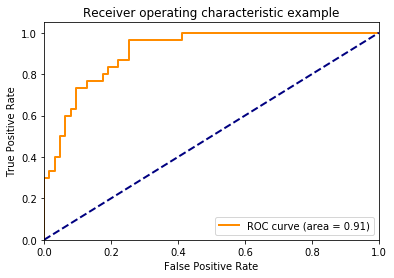

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/parkinsons 



/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Results

-- Global Precision --
0.8813559322033898


-- General Report --
              precision    recall  f1-score   support

         yes       0.90      0.96      0.93        46
          no       0.80      0.62      0.70        13

    accuracy                           0.88        59
   macro avg       0.85      0.79      0.81        59
weighted avg       0.88      0.88      0.88        59



-- Confusion Matrix --
    0  1
0  44  2
1   5  8

ROC Curve: 

ROC AUC:  0.8010033444816054


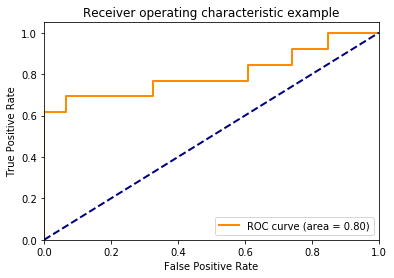

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/ionophere 



/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Results

-- Global Precision --
0.7904761904761904


-- General Report --
              precision    recall  f1-score   support

         yes       0.69      0.73      0.71        37
          no       0.85      0.82      0.84        68

    accuracy                           0.79       105
   macro avg       0.77      0.78      0.77       105
weighted avg       0.79      0.79      0.79       105



-- Confusion Matrix --
    0   1
0  27  10
1  12  56

ROC Curve: 

ROC AUC:  0.802066772655008


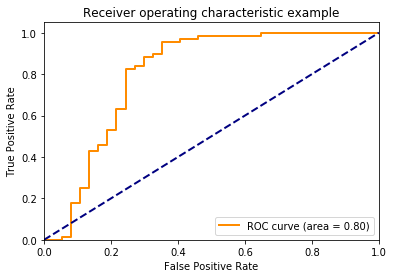

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/sentiment-polarity 



/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/codigoriginal/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Results

-- Global Precision --
0.6285714285714286


-- General Report --
              precision    recall  f1-score   support

         yes       0.62      0.48      0.54        48
          no       0.63      0.75      0.69        57

    accuracy                           0.63       105
   macro avg       0.63      0.62      0.61       105
weighted avg       0.63      0.63      0.62       105



-- Confusion Matrix --
    0   1
0  23  25
1  14  43

ROC Curve: 

ROC AUC:  0.6831140350877192


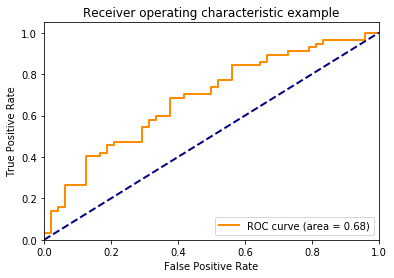

In [4]:
databases_path = '../../Databases/Sinteticas'
paths = get_databases_path(databases_path)

for database in paths:
    print('------------------------------------------------------------------------')
    print("Database:", database, '\n')

    # Obtain the attributes and labels
    attr_df = get_database(database, 'database_attr.csv')
    labels_df = get_database(database, 'database_labels.csv') 

    attr_df = MaxMinScaler(attr_df)

    # Split in Training and Test Sets
    X_train, X_test, y_train, y_test = split_train_test_ma(attr_df, labels_df)

    # Train MAE Model
    W = train_mae(X_train, y_train)

    X_test.loc[:,('b')] = 1
    predtest = sigmoid(np.dot(X_test,W))
    y_pred = np.round(predtest).astype(bool)

    print("\nResults\n")
    eval_model_roc_2(y_test, y_pred, predtest)